randseed: 4896
size_D: 60
NOTE: initial_D has been set to default 100. You may also input any desired integer value, or set to None to generate a random value.

NOTE: Unless other parameters (dist_alpha/beta, dist_lower/upper, var_D) are specified, initial_D will be taken as the mean demand.
      The probability distribution for demand has been generated based on this mean value.

Demand Distribution: GAMMA
alpha: 59.79
beta: 1.67
Demand Distribution Mean: 100
Demand Distribution Variance: 167.25 


forecast_alpha: 0.2847602195312029
forecast_beta: 0.27538452151133097
D_1 (randomly generated historical Demand reading): 116.243093489298
NOTE: Seasonals have been randomly generated.

seasonal_variation (as fraction of mean_D): 0.1
seasonals:
 [ 7.84  0.43 -1.66  1.87 -0.21 -5.12 -6.66 -1.02  3.54 -8.94 -3.05 -1.42] 


 Generated Demand Forecast:
[123. 107. 125. 109. 108.  97. 120. 129. 117. 112. 107. 104. 132. 145.
 136. 130. 110. 127. 126. 126. 144. 125. 119. 133. 112. 140. 152. 141.
 

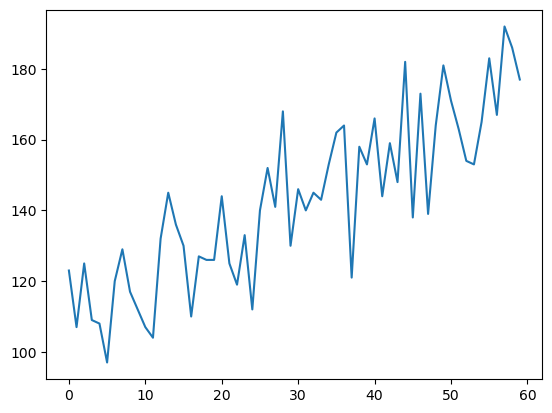

In [2]:
import numpy as np
from scipy.stats import truncnorm
import pandas as pd
import matplotlib.pyplot as plt
import csv


#DEMAND FORECAST GENERATOR
def demaforgen(randseed: int = None, forecast_type:str = "seas", dist_type:str = "gamma", randomness:bool = True,
               initial_D: float = 100, size_D: int = None, var_D: float = None,
               dist_alpha: float = None, dist_beta: float = None,
               dist_lower: float = None, dist_upper: float = None,
               forecast_alpha: float = None, forecast_beta: float = None,
               season_length: int = 12, seasonals:list = None, seasonal_variation: float = 0.1,):

    #0. Prep work
    
    #0.1 Set & display seed for reproducibility
    if randseed is None:
        randseed = np.random.randint(10000)
    np.random.seed(randseed)
    print("randseed:", randseed)

    #0.2 Randomize & display Demand array size and mean
    if size_D is None: size_D = 12*np.random.randint(2,6)
    print("size_D:", size_D)

    if initial_D==100: default=True; print("NOTE: initial_D has been set to default 100. You may also input any desired integer value, or set to None to generate a random value.\n")
    else: default=False
    if initial_D is None:
        initial_D = np.random.randint(1,10000)
        print("initial_D:", initial_D)
        print("NOTE: initial_D has been randomly generated.\n")

    if type(size_D)!=int or type(initial_D)!=int or size_D<=0 or initial_D<=0 or (var_D is not None and var_D<=0):
        return "ERROR: size_D, initial_D, and var_D must be integers greater than 0."
    
    #0.3 Obtain & display necessary parameters based on input probability distribution of demand.
    if forecast_type=="stat" and randomness == False: None
    else:
        print("NOTE: Unless other parameters (dist_alpha/beta, dist_lower/upper, var_D) are specified, initial_D will be taken as the mean demand.")
        print("      The probability distribution for demand has been generated based on this mean value.\n")
        mean_D = initial_D

        if dist_type=="gamma":
            if (dist_alpha and dist_beta) is None:
                if var_D is not None: #User input: mean_D and var_D
                    dist_alpha = (mean_D**2)/var_D
                    dist_beta  = var_D/mean_D

                else: #User input: mean_D only (DEFAULT)
                    dist_alpha = np.random.uniform(1,100)
                    dist_beta = mean_D/dist_alpha
                    var_D = dist_beta*mean_D
            
            else: #User input: dist_alpha and dist_beta
                mean_D = dist_alpha*dist_beta
                var_D = dist_beta*mean_D

                if default:
                    print(" NOTE: Default mean demand = 100 value has been overwritten to mean_D = dist_alpha*dist_beta.\n")
                
                if dist_alpha <=0 or dist_beta <=0:
                    return "ERROR: alpha and/or beta must be a positive value."

                elif (dist_alpha is None) or (dist_beta is None):
                    return "ERROR: Please specify BOTH dist_alpha AND dist_beta in input, OR neither."

                elif var_D is not None: #User input: mistakenly defining alpha and beta together with var_D
                    mean_D = dist_alpha*dist_beta
                    print("WARNING: User specified dist_alpha/beta and var_D values conflict.")
                    print("         Mean and variance overwritten to mean_D = dist_alpha*dist_beta and var_D = dist_alpha*(dist_beta**2).")
                    print("         If specifying dist_alpha and dist_beta in input, please leave var_D blank.\n")

            print("Demand Distribution: GAMMA")            
            print("alpha:", np.round(dist_alpha,2))
            print("beta:", np.round(dist_beta,2))
            print("Demand Distribution Mean:", np.round(mean_D, 2))
            print("Demand Distribution Variance:", np.round(var_D, 2), "\n")


        elif dist_type=="poisson":
            if var_D is not None:
                print("NOTE: Mean and Variance are supposed to be the same for Poisson distribution.")
                print("      The mean_D value has been overwritten to be equal to the input var_D.\n")
                mean_D = var_D

            print("Demand Distribution: POISSON")
            print("lambda:", mean_D, "= Demand Distribution Mean = Demand Distribution Variance", "\n")

        elif dist_type=="uniform":
            if (dist_lower and dist_upper) is None:
                if var_D is not None: #User input: mean_D and var_D
                    dist_lower = mean_D - 0.5*np.sqrt(12*var_D)
                    dist_upper = mean_D + 0.5*np.sqrt(12*var_D)

                else: #User input: mean_D only (DEFAULT) 
                    dist_lower = 0
                    dist_upper = 2*mean_D
                    var_D = ((dist_upper-dist_lower)**2)/12
                    print("NOTE: Range for Demand Distribution (uniform) set to between 0 and 2*mean_D.")
                    print("To adjust this range, input either var_D or dist_lower & dist_upper values.\n")

            else: #User input: dist_lower and dist_upper
                
                if dist_lower <=0 or dist_upper <=0:
                    return "ERROR: lower/upper limits for demand must be positive values. Input var_D may be too high."

                if default:
                    print("WARNING: Default mean_D = 100 value has been overwritten to 0.5*(dist_lower+dist_upper).\n")

                elif (dist_lower is None) or (dist_upper is None):
                    return "ERROR: Please specify BOTH dist_lower AND dist_upper in input, OR neither."

                elif (mean_D is not None) or (var_D is not None): #User input: mistakenly defines range together with var_D
                    print("ERROR: User specified dist_lower/upper and mean_D/var_D values conflict.")
                    return "       Please specify either BOTH lower and upper, OR mean_D, OR var_D, OR both mean_D and var_D."

                mean_D = 0.5*(dist_lower+dist_upper)
                var_D = ((dist_upper-dist_lower)**2)/12

            print("Demand Distribution: UNIFORM")
            print("Range:", (dist_lower, dist_upper))
            print("Demand Distribution Mean:", np.round(mean_D, 2))
            print("Demand Distribution Variance:", np.round(var_D, 2), "\n")


        elif dist_type=="normal":
            print("NOTE: Since Demand must be >=0, Normal Distribution has been truncated at 0.\n")

            if var_D is None:
                var_D = 1
                print("WARNING: No input var_D specified for Normal Distribution. Variance set to scipy's truncnorm default (var_D = 1).\n.")

            if (dist_lower and dist_upper) is None:
                dist_lower = 0
                dist_upper = np.inf

                print("NOTE: Range for Demand Distribution (truncated normal) set to between 0 and positive infinity by default.")
                print("To adjust this range, input dist_lower & dist_upper values.\n")

            else: #User input: dist_lower and dist_upper            
                if dist_lower <=0 or dist_upper <=0:
                    return "ERROR: lower/upper limits for demand must be positive values."

                elif (dist_lower is None) or (dist_upper is None):
                    return "ERROR: Please specify BOTH dist_lower AND dist_upper in input, OR neither."

            trunc_lower = (-dist_lower)/np.sqrt(var_D) #Distances from mean (scipy needs this).
            trunc_upper = dist_upper/np.sqrt(var_D) #Distances from mean (scipy needs this).

            print("Demand Distribution: TRUNCATED NORMAL")
            print("Range:", [dist_lower, dist_upper])
            print("Mean:", np.round(mean_D, 2))
            print("Variance:", np.round(var_D, 2), "\n")

        else:
            return 'ERROR: dist_type should be "gamma" (default), "poisson", "uniform", or "normal".'


    #1. Stationary Series
    if forecast_type=="stat":
        if randomness:
            if dist_type=="gamma": Demand = np.round(np.random.gamma(dist_alpha, dist_beta, size=size_D))
            if dist_type=="poisson": Demand = np.round(np.random.poisson(lam=mean_D, size=size_D))
            if dist_type=="uniform": Demand = np.round(np.random.uniform(dist_lower, dist_upper, size=size_D))
            if dist_type=="normal": Demand = np.round(truncnorm.rvs(trunc_lower, trunc_upper, loc=(mean_D-np.sqrt(var_D)), scale=np.sqrt(var_D), size=size_D))
        
        else: Demand = np.full(size_D, initial_D)

    #2. Trend
    elif (forecast_type=="trend") or (forecast_type=="seas"):

        if forecast_alpha is None:
            forecast_alpha = np.random.uniform(0.1,0.3)
            print("WARNING: forecast_alpha has been randomly generated. Input a value for forecast_alpha if desired.")

        if forecast_beta is None:
            forecast_beta = np.random.uniform(0.099,0.3)
            print("WARNING: forecast_beta has been randomly generated. Input a value for forecast_beta if desired.\n")

        print("forecast_alpha:", forecast_alpha)
        print("forecast_beta:", forecast_beta)

        if dist_type=="gamma": D_1 = np.random.gamma(dist_alpha, dist_beta)
        if dist_type=="poisson": D_1 = np.random.poisson(lam=mean_D)
        if dist_type=="uniform": D_1 = np.random.uniform(dist_lower, dist_upper)
        if dist_type=="normal": D_1 = truncnorm.rvs(trunc_lower, trunc_upper, loc=(mean_D-np.sqrt(var_D)), scale=np.sqrt(var_D))
        print("D_1 (randomly generated historical Demand reading):", D_1)

        #3. Seasonality
        if forecast_type=="seas":
            if (seasonal_variation is not None) and (seasonals is not None):
                print("WARNING: Specified seasonals will override seasonal_variation value.\n")

            if seasonals is None:
                seasonals = np.random.uniform(-seasonal_variation*mean_D, seasonal_variation*mean_D, size=season_length)
                print("NOTE: Seasonals have been randomly generated.\n")

            print("seasonal_variation (as fraction of mean_D):", seasonal_variation)
            print("seasonals:\n", np.round(seasonals,2), "\n")

        #Generate Demand Forecast for #2 and #3
        Demand = []
        a_1 = mean_D
        a_2 = forecast_alpha*D_1 + (1-forecast_alpha)*mean_D
        b = forecast_beta*(a_2 - a_1)

        for i in range(size_D):
            Demand.append((a_2 + (i+1)*b))

            #3.1 Add seasonality if needed
            if forecast_type=="seas":
                season = i % season_length
                Demand[i] += seasonals[season]

            #4. Add random variation
            if randomness:
                if dist_type=="gamma":
                    if Demand[i]>0:
                        dist_alpha = (Demand[i]**2)/var_D
                        dist_beta  = var_D/Demand[i]
                        Demand[i] = np.random.gamma(dist_alpha, dist_beta)

                if dist_type=="poisson": Demand[i] = np.random.poisson(lam=Demand[i])
                if dist_type=="uniform":
                    if i==0:
                        dist_lower += Demand[i] - D_1
                        dist_upper += Demand[i] - D_1
                    else:
                        dist_lower += Demand[i] - Demand[i-1]
                        dist_upper += Demand[i] - Demand[i-1]

                    if dist_lower < 0: dist_lower = 0
                    if dist_upper < 0: Demand[i] = 0
                    Demand[i] = np.random.uniform(dist_lower, dist_upper)

                if dist_type=="normal":
                    if i==0:
                        trunc_lower += (Demand[i] - D_1)/np.sqrt(var_D)
                        trunc_upper += (Demand[i] - D_1)/np.sqrt(var_D)                                            
                    else:
                        trunc_lower += (Demand[i] - Demand[i-1])/np.sqrt(var_D)
                        trunc_upper += (Demand[i] - Demand[i-1])/np.sqrt(var_D)                                           
                    Demand[i] = truncnorm.rvs(trunc_lower, trunc_upper, loc=Demand[i], scale=np.sqrt(var_D))        

            if Demand[i] <=0:
                warning = True
                Demand[i] = 0
            else: warning = False

        if warning: print("WARNING: Some values of Demand are 0. Variance (var_D) or trend slope (forecast_beta) may be too high!\n")

    else:
        return "ERROR: forecast_type should be 'seas' (default), 'trend', or 'stat'."

    print("\n Generated Demand Forecast:")
    return np.round(Demand)

#ALL OTHER PARAMETERS
n_t = [22, 20, 23, 20, 23, 22, 21, 23, 21, 22, 22, 21] #260 working days a year according to MOM

c_I = np.random.uniform(0, 100000)
c_R = np.random.uniform(0, 100000)
c_O = np.random.uniform(0, 100000)
c_U = np.random.uniform(0, 100000)
c_S = np.random.uniform(0, 100000)
c_H = truncnorm.rvs(0, np.inf, loc=(2406.60-np.sqrt(1000)), scale=np.sqrt(1000))
c_F = truncnorm.rvs(0, np.inf, loc=(173490-np.sqrt(1000)), scale=np.sqrt(1000))

T = 12*np.random.randint(2,6)
K = np.random.uniform(0, 100)
W_0 = np.random.uniform(0, 100000)
I_0 = np.random.uniform(0, 100000)

Demand = demaforgen(randseed = 4896, size_D = T)

print(Demand)
plt.plot(Demand)

#Create a DataFrame collating all parameters and save to a CSV file

simul_data = {'T':[i for i in range(1,T+1)], 'K': [K], 'n_t': n_t, 
              'W_0': [W_0], 'I_0': [I_0],
              'c_H': [c_H], 'c_F': [c_F], 'c_I': [c_I],
              'c_R': [c_R], 'c_O': [c_O], 'c_U': [c_U], 'c_S': [c_S],
              'Demand': Demand}

max_length = len(Demand)

csv_file_path = 'sample_upload.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(simul_data.keys())
    
    # Write the rows
    for i in range(max_length):
        row = [simul_data[key][i] if i < len(simul_data[key]) else '' for key in simul_data.keys()]
        writer.writerow(row)